In [1]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


Load one image from each class (SSA / HP)

In [2]:
from PIL import Image #import pillow

img_train = Image.open('C:\\Users\\xiuli\\MHIST\\folder\\images\\MHIST_aaa.png') #use one SSA image
print(img_train)

img_test = Image.open('C:\\Users\\xiuli\\MHIST\\folder\\images\\MHIST_aag.png') #use one HP image
print(img_test)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x1FA9C951BD0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x1FAA2316550>


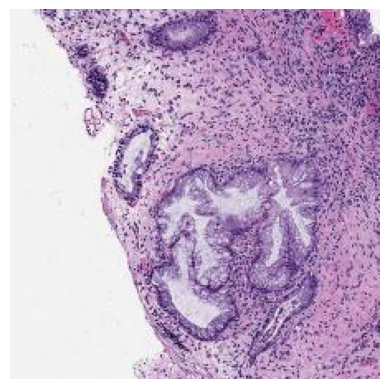

In [3]:
import matplotlib.image as mpimg #import matplotlib
import matplotlib.pyplot as plt

imgplot = plt.imshow(img_train) #show the image
plt.axis('off')
plt.show()

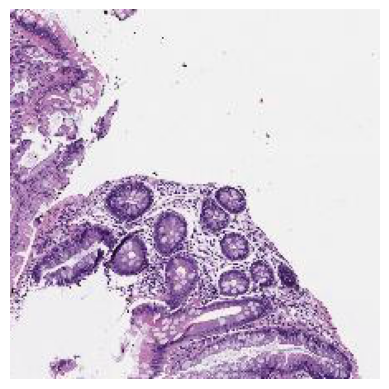

In [4]:
imgplot = plt.imshow(img_test) #show the image
plt.axis('off')
plt.show()

Load every data into huge x,y

In [5]:
import glob #import glob
import os

image_list = glob.glob('C:\\Users\\xiuli\\MHIST\\folder\\images\\*.png') #use glob to get list

In [6]:
import pandas as pd #import pandas
from sklearn.model_selection import train_test_split #import train_test_split

annotations = pd.read_csv("annotations.csv") #import the spreadsheet and save it into a variable
labels = annotations["Majority Vote Label"] #from the spreadsheet, store the label column

newlist = labels.tolist() #turn the labels array into a list

binary = [] #create an empty list to turn the labels into binary digits

#use a for loop to run through every item in the list
for n in range(len(newlist)): 
    if newlist[n] == "SSA": #if the label is SSA, add 0 into the list
        binary.append(0)
    else: #if the label is HP, add 1 into the list
        binary.append(1)

In [7]:
import keras

#use keras to split the dataset into train and test (we will be using the test as validation and testing)
train_loader, test_loader = keras.utils.image_dataset_from_directory(
    directory=r"C:\Users\xiuli\MHIST\folder\images",
    labels=binary,
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=0,
    validation_split=0.2,
    subset="both",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

Found 3152 files belonging to 2 classes.
Using 2522 files for training.
Using 630 files for validation.


In [8]:
import numpy as np

train_classes = []
train_count_ssa = 0
train_count_hp = 0

test_classes = []
test_count_ssa = 0
test_count_hp = 0

for image, labels in train_loader:
    train_classes.append(labels)
train_classes = np.concatenate(train_classes)
train_classes = train_classes.tolist()

for n in range(len(train_classes)):
    if train_classes[n] == [0.0]:
        train_count_ssa += 1
    else:
        train_count_hp += 1

for image, labels in test_loader:
    test_classes.append(labels)
test_classes = np.concatenate(test_classes)
test_classes = test_classes.tolist()

for n in range(len(test_classes)):
    if test_classes[n] == [0.0]:
        test_count_ssa += 1
    else:
        test_count_hp += 1

In [9]:
from tabulate import tabulate

col_names = ["", "SSA", "HP", "Total"]

data = [["Train", train_count_ssa, train_count_hp, len(train_classes)],
        ["Test", test_count_ssa, test_count_hp, len(test_classes)],
        ["Total", train_count_ssa + test_count_ssa, train_count_hp + test_count_hp, len(train_classes) + len(test_classes)]]

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════╤═══════╤══════╤═════════╕
│       │   SSA │   HP │   Total │
╞═══════╪═══════╪══════╪═════════╡
│ Train │   793 │ 1729 │    2522 │
├───────┼───────┼──────┼─────────┤
│ Test  │   197 │  433 │     630 │
├───────┼───────┼──────┼─────────┤
│ Total │   990 │ 2162 │    3152 │
╘═══════╧═══════╧══════╧═════════╛


### Keras MHIST based off MNIST Model

In [10]:
from keras import layers #import layers from keras

input_shape = (224, 224, 3) #define the shape of the original images

#create a model based off the mnist model
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(3, kernel_size=(7, 7), activation="relu"),  #downsize the image size
        layers.MaxPooling2D(pool_size=(2, 2)), 
        layers.Conv2D(10, kernel_size=(7, 7), activation="relu"), #downsize again
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(), #flatten into 1-D
        layers.Dropout(0.2), #dropout rate of 20% probability
        layers.Dense(1, activation="sigmoid"), #put it into the 1 element, and use sigmoid to turn it into 0 or 1
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 218, 218, 3)    │           444 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 109, 109, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 103, 103, 10)   │         1,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 51, 51, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 26010)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26010)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        26,011 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,935 (109.12 KB)

 Trainable params: 27,935 (109.12 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
batch_size = 128
epochs = 15

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(
    x=train_loader,
    y=None,
    batch_size=batch_size,
    epochs=epochs,
    verbose="auto",
    callbacks=None,
    validation_split=0.0,
    validation_data=test_loader,
    shuffle=True,
    class_weight=None, #penalty for guessing incorrectly, using a dictionary
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
)

Epoch 1/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step - accuracy: 0.6294 - loss: 36.0719 - val_accuracy: 0.6857 - val_loss: 0.7480
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.6939 - loss: 0.6914 - val_accuracy: 0.6810 - val_loss: 0.7069
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - accuracy: 0.6986 - loss: 0.6661 - val_accuracy: 0.6762 - val_loss: 0.7107
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.7032 - loss: 0.6396 - val_accuracy: 0.6762 - val_loss: 0.7057
Epoch 5/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - accuracy: 0.7076 - loss: 0.6263 - val_accuracy: 0.6841 - val_loss: 0.7035
Epoch 6/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - accuracy: 0.7083 - loss: 0.6151 - val_accuracy: 0.6921 - val_loss: 0.6977
Epoch 7/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.7184 - loss: 0.5988 - val_accuracy: 0.6873 - val_loss: 0.7451
Epoch 8/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.7185 - loss: 0.5905 - val_acc

In [12]:
score = model.evaluate(test_loader, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.9300987720489502
Test accuracy: 0.6571428775787354


In [13]:
predictions = []
groundtrues = []

for x,y in train_loader:
    y_pred = model(x)
    predictions.append(y_pred)
    groundtrues.append(y)

predictions = np.concatenate(predictions)
groundtrues = np.concatenate(groundtrues)

In [14]:
testpredictions = []
testgroundtrues = []

for x,y in test_loader:
    y_pred = model(x)
    testpredictions.append(y_pred)
    testgroundtrues.append(y)

testpredictions = np.concatenate(testpredictions)
testgroundtrues = np.concatenate(testgroundtrues)

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

print("The accuracy score for the train loader is: ", accuracy_score(groundtrues, predictions.round()))
print("The F1 score for the train loader is: ", f1_score(groundtrues, predictions.round()), "\n")

conf = confusion_matrix(groundtrues, predictions.round())
print("The confusion matrix for the train loader is: \n", conf, "\n")
print("The sensitivity score of SSA for the train loader is: ", conf[0,0]/(conf[0,0]+conf[0,1]))
print("The specificity score of HP for the train loader is: ", conf[1,1]/(conf[1,1]+conf[1,0]))

The accuracy score for the train loader is:  0.760904044409199
The F1 score for the train loader is:  0.8509270704573548 

The confusion matrix for the train loader is: 
 [[ 198  595]
 [   8 1721]] 

The sensitivity score of SSA for the train loader is:  0.24968474148802017
The sensitivity score of HP for the train loader is:  0.995373048004627 

The specificity score of SSA for the train loader is:  0.995373048004627
The specificity score of HP for the train loader is:  0.24968474148802017


In [16]:
print("The accuracy score for the test loader is: ", accuracy_score(testgroundtrues, testpredictions.round()))
print("The F1 score for the test loader is: ", f1_score(testgroundtrues, testpredictions.round()), "\n")

conf = confusion_matrix(testgroundtrues, testpredictions.round())
print("The confusion matrix for the test loader is: \n", conf, "\n")
print("The sensitivity score of SSA for the test loader is: ", conf[0,0]/(conf[0,0]+conf[0,1]))
print("The specificity score of HP for the test loader is: ", conf[1,1]/(conf[1,1]+conf[1,0]))

The accuracy score for the test loader is:  0.6571428571428571
The F1 score for the test loader is:  0.7882352941176471 

The confusion matrix for the test loader is: 
 [[ 12 185]
 [ 31 402]] 

The sensitivity score of SSA for the test loader is:  0.06091370558375635
The sensitivity score of HP for the test loader is:  0.9284064665127021 

The specificity score of SSA for the test loader is:  0.9284064665127021
The specificity score of HP for the test loader is:  0.06091370558375635


The AUC score of the train loader is:  0.7719468425647493
The AUC score of the test loader is:  0.517455832874175


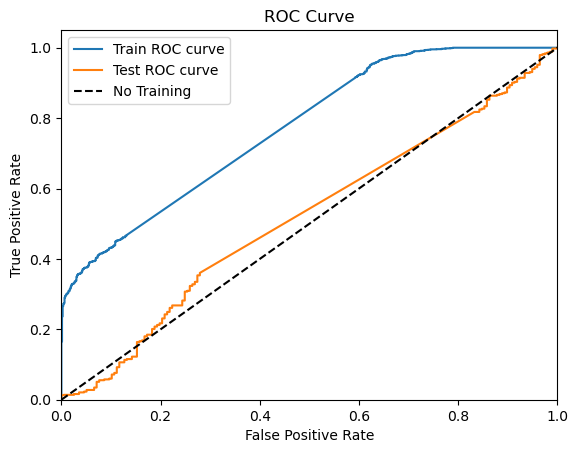

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#calculate ROC curve for train loader
fpr, tpr, thresholds = roc_curve(groundtrues, predictions) 
roc_auc = auc(fpr, tpr)
print("The AUC score of the train loader is: ", roc_auc)

fpr2, tpr2, thresholds2 = roc_curve(testgroundtrues, testpredictions) 
roc_auc2 = auc(fpr2, tpr2)
print("The AUC score of the test loader is: ", roc_auc2)

# plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='Train ROC curve' % roc_auc)
plt.plot(fpr2, tpr2, label='Test ROC curve' % roc_auc2)
plt.plot([0, 1], [0, 1], 'k--', label='No Training')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

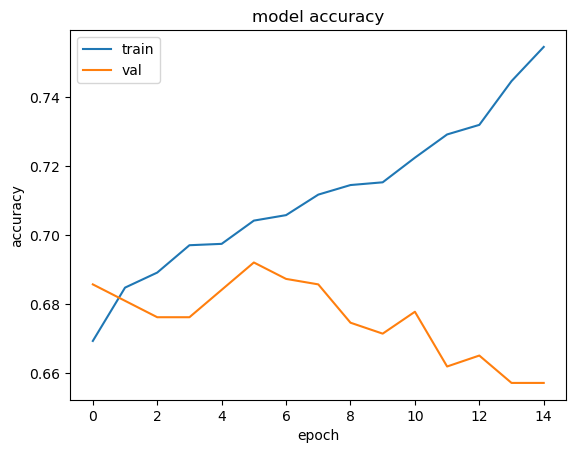

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

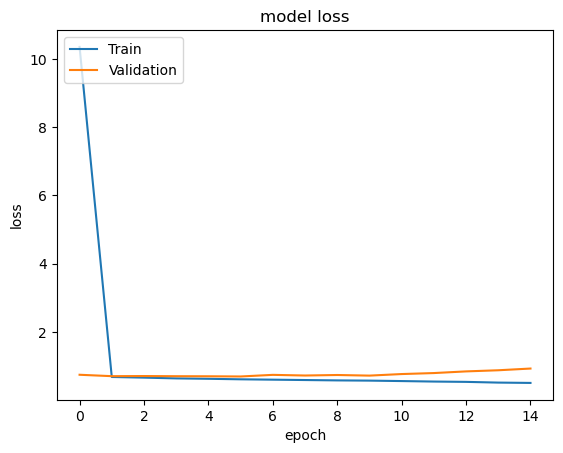

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
img = keras.utils.load_img('C:\\Users\\xiuli\\MHIST\\folder\\images\\MHIST_aaa.png') # SSA image
img_array = keras.utils.img_to_array(img)
img_array = np.array([img_array]) 
predictions = model.predict(img_array)
class_id = np.argmax(predictions, axis = 1)
print(class_id)

#note: since I converted SSA and HP labels into binary digits, SSA is 0 and HP is 1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
[0]


In [21]:
img = keras.utils.load_img('C:\\Users\\xiuli\\MHIST\\folder\\images\\MHIST_aag.png') # HP image
img_array = keras.utils.img_to_array(img)
img_array = np.array([img_array]) 
predictions = model.predict(img_array)
class_id = np.argmax(predictions, axis = 1)
print(class_id)

#note: since I converted SSA and HP labels into binary digits, SSA is 0 and HP is 1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[0]


### ResNet Model

In [22]:
from keras.applications.resnet50 import ResNet50

model2 = ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1,
    classifier_activation="sigmoid",
    )

model2.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [23]:
batch_size = 128
epochs = 10

model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history2 = model2.fit(
    x=train_loader,
    y=None,
    batch_size=batch_size,
    epochs=epochs,
    verbose="auto",
    callbacks=None,
    validation_split=0.0,
    validation_data=test_loader,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 929s 10s/step - accuracy: 0.6258 - loss: 1.1689 - val_accuracy: 0.6873 - val_loss: 27.7665
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 815s 10s/step - accuracy: 0.6241 - loss: 0.7077 - val_accuracy: 0.3175 - val_loss: 0.7510
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 821s 10s/step - accuracy: 0.6826 - loss: 0.6210 - val_accuracy: 0.3714 - val_loss: 0.7591
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 832s 11s/step - accuracy: 0.6842 - loss: 0.6130 - val_accuracy: 0.6873 - val_loss: 0.7425
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 835s 11s/step - accuracy: 0.6333 - loss: 0.6925 - val_accuracy: 0.5698 - val_loss: 0.8351
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 830s 11s/step - accuracy: 0.6780 - loss: 0.6328 - val_accuracy: 0.6873 - val_loss: 1.3552
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 800s 10s/step - accuracy: 0.6722 - loss: 0.6277 - val_accuracy: 0.5048 - val_loss: 1.2051
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 792s 10s/step - accuracy: 0.6806 - loss: 0.6505 - val_accuracy: 0

In [24]:
score2 = model2.evaluate(test_loader, verbose=0)
print("Test loss:", score2[0])
print("Test accuracy:", score2[1])

Test loss: 20.472110748291016
Test accuracy: 0.6873015761375427


In [25]:
resnet_predictions = []
resnet_groundtrues = []

for x,y in train_loader:
    y_pred = model2(x)
    resnet_predictions.append(y_pred)
    resnet_groundtrues.append(y)

resnet_predictions = np.concatenate(resnet_predictions)
resnet_groundtrues = np.concatenate(resnet_groundtrues)

In [26]:
resnet_testpredictions = []
resnet_testgroundtrues = []

for x,y in test_loader:
    y_pred = model2(x)
    resnet_testpredictions.append(y_pred)
    resnet_testgroundtrues.append(y)

resnet_testpredictions = np.concatenate(resnet_testpredictions)
resnet_testgroundtrues = np.concatenate(resnet_testgroundtrues)

In [27]:
print("The accuracy score for the train loader is: ", accuracy_score(resnet_groundtrues, resnet_predictions.round()))
print("The F1 score for the train loader is: ", f1_score(resnet_groundtrues, resnet_predictions.round()), "\n")

conf = confusion_matrix(resnet_groundtrues, resnet_predictions.round())
print("The confusion matrix for the train loader is: \n", conf, "\n")
print("The sensitivity score of SSA for the train loader is: ", conf[0,0]/(conf[0,0]+conf[0,1]))
print("The specificity score of HP for the train loader is: ", conf[1,1]/(conf[1,1]+conf[1,0]))

The accuracy score for the train loader is:  0.6855670103092784
The F1 score for the train loader is:  0.8134556574923547 

The confusion matrix for the train loader is: 
 [[   0  793]
 [   0 1729]] 

The sensitivity score of SSA for the train loader is:  0.0
The sensitivity score of HP for the train loader is:  1.0 

The specificity score of SSA for the train loader is:  1.0
The specificity score of HP for the train loader is:  0.0


In [28]:
print("The accuracy score for the train loader is: ", accuracy_score(resnet_testgroundtrues, resnet_testpredictions.round()))
print("The F1 score for the train loader is: ", f1_score(resnet_testgroundtrues, resnet_testpredictions.round()), "\n")

conf = confusion_matrix(resnet_testgroundtrues, resnet_testpredictions.round())
print("The confusion matrix for the train loader is: \n", conf, "\n")
print("The sensitivity score of SSA for the train loader is: ", conf[0,0]/(conf[0,0]+conf[0,1]))
print("The specificity score of HP for the train loader is: ", conf[1,1]/(conf[1,1]+conf[1,0]))

The accuracy score for the train loader is:  0.6873015873015873
The F1 score for the train loader is:  0.8146754468485419 

The confusion matrix for the train loader is: 
 [[  0 197]
 [  0 433]] 

The sensitivity score of SSA for the train loader is:  0.0
The sensitivity score of HP for the train loader is:  1.0 

The specificity score of SSA for the train loader is:  1.0
The specificity score of HP for the train loader is:  0.0


The AUC score of the train loader is:  0.49661840117803485
The AUC score of the test loader is:  0.5087513628210689


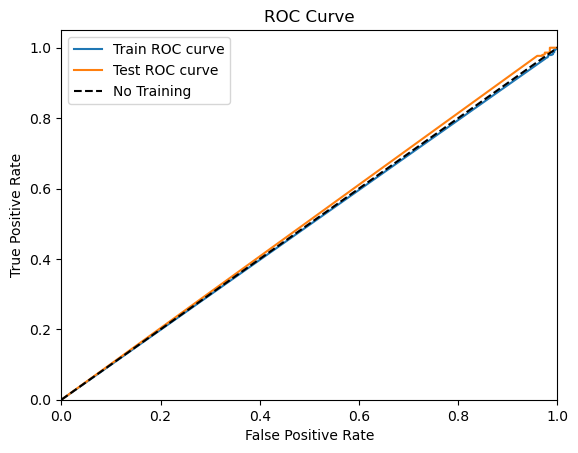

In [29]:
#calculate ROC curve for train loader
fpr, tpr, thresholds = roc_curve(resnet_groundtrues, resnet_predictions) 
roc_auc = auc(fpr, tpr)
print("The AUC score of the train loader is: ", roc_auc)

fpr2, tpr2, thresholds2 = roc_curve(resnet_testgroundtrues, resnet_testpredictions) 
roc_auc2 = auc(fpr2, tpr2)
print("The AUC score of the test loader is: ", roc_auc2)

# plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='Train ROC curve' % roc_auc)
plt.plot(fpr2, tpr2, label='Test ROC curve' % roc_auc2)
plt.plot([0, 1], [0, 1], 'k--', label='No Training')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

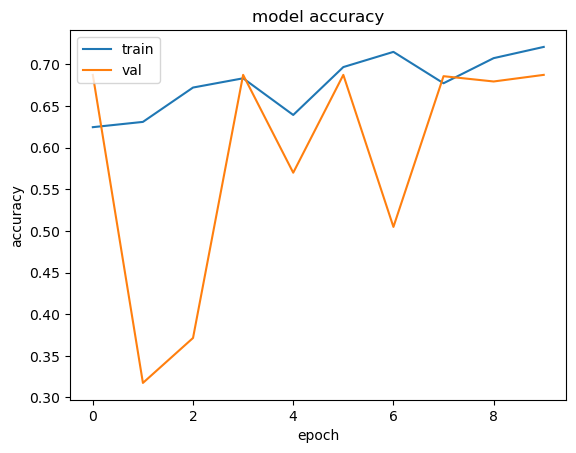

In [30]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

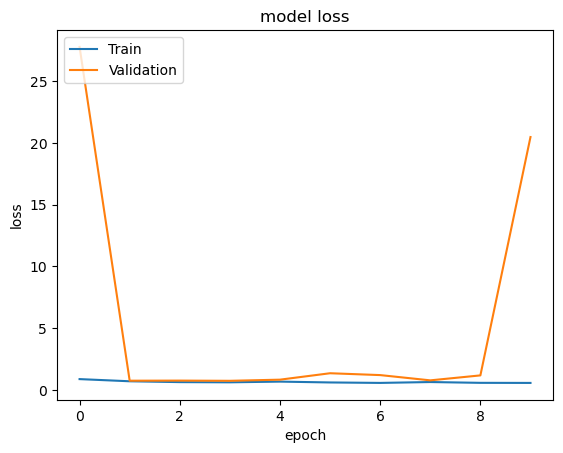

In [31]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [32]:
img = keras.utils.load_img('C:\\Users\\xiuli\\MHIST\\folder\\images\\MHIST_aaa.png') # SSA image
img_array = keras.utils.img_to_array(img)
img_array = np.array([img_array]) 
predictions = model2.predict(img_array)
class_id = np.argmax(predictions, axis = 1)
print(class_id)

#note: since I converted SSA and HP labels into binary digits, SSA is 0 and HP is 1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[0]


In [33]:
img = keras.utils.load_img('C:\\Users\\xiuli\\MHIST\\folder\\images\\MHIST_aag.png') # HP image
img_array = keras.utils.img_to_array(img)
img_array = np.array([img_array]) 
predictions = model2.predict(img_array)
class_id = np.argmax(predictions, axis = 1)
print(class_id)

#note: since I converted SSA and HP labels into binary digits, SSA is 0 and HP is 1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
[0]


### MobileNet Model

In [34]:
from keras.applications.mobilenet import MobileNet

model3 = keras.applications.MobileNet(
    input_shape=None,
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights=None,
    input_tensor=None,
    pooling=None,
    classes=1,
    classifier_activation="sigmoid",
)

model3.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,229,889 (12.32 MB)

 Trainable params: 3,208,001 (12.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [35]:
batch_size = 128
epochs = 10

model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history3 = model3.fit(
    x=train_loader,
    y=None,
    batch_size=batch_size,
    epochs=epochs,
    verbose="auto",
    callbacks=None,
    validation_split=0.0,
    validation_data=test_loader,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.6512 - loss: 0.6833 - val_accuracy: 0.6873 - val_loss: 0.6246
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.6537 - loss: 0.6622 - val_accuracy: 0.6873 - val_loss: 0.6898
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.6694 - loss: 0.6370 - val_accuracy: 0.6873 - val_loss: 0.8719
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.6965 - loss: 0.6214 - val_accuracy: 0.6873 - val_loss: 0.8020
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.6854 - loss: 0.6266 - val_accuracy: 0.6873 - val_loss: 0.7071
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.6892 - loss: 0.6159 - val_accuracy: 0.6873 - val_loss: 0.7064
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.6980 - loss: 0.6056 - val_accuracy: 0.6873 - val_loss: 0.6703
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.7277 - loss: 0.5622 - val_accuracy: 0.6635 - v

In [36]:
score3 = model3.evaluate(test_loader, verbose=0)
print("Test loss:", score3[0])
print("Test accuracy:", score3[1])

Test loss: 0.9936726689338684
Test accuracy: 0.6380952596664429


In [37]:
mobnet_predictions = []
mobnet_groundtrues = []

for x,y in train_loader:
    y_pred = model3(x)
    mobnet_predictions.append(y_pred)
    mobnet_groundtrues.append(y)

mobnet_predictions = np.concatenate(mobnet_predictions)
mobnet_groundtrues = np.concatenate(mobnet_groundtrues)

In [38]:
mobnet_testpredictions = []
mobnet_testgroundtrues = []

for x,y in test_loader:
    y_pred = model3(x)
    mobnet_testpredictions.append(y_pred)
    mobnet_testgroundtrues.append(y)

mobnet_testpredictions = np.concatenate(mobnet_testpredictions)
mobnet_testgroundtrues = np.concatenate(mobnet_testgroundtrues)

In [39]:
print("The accuracy score for the train loader is: ", accuracy_score(mobnet_groundtrues, mobnet_predictions.round()))
print("The F1 score for the train loader is: ", f1_score(mobnet_groundtrues, mobnet_predictions.round()), "\n")

conf = confusion_matrix(mobnet_groundtrues, mobnet_predictions.round())
print("The confusion matrix for the train loader is: \n", conf, "\n")
print("The sensitivity score of SSA for the train loader is: ", conf[0,0]/(conf[0,0]+conf[0,1]))
print("The specificity score of HP for the train loader is: ", conf[1,1]/(conf[1,1]+conf[1,0]))

The accuracy score for the train loader is:  0.7708168120539255
The F1 score for the train loader is:  0.8436147186147187 

The confusion matrix for the train loader is: 
 [[ 385  408]
 [ 170 1559]] 

The sensitivity score of SSA for the train loader is:  0.4854981084489281
The sensitivity score of HP for the train loader is:  0.9016772700983228 

The specificity score of SSA for the train loader is:  0.9016772700983228
The specificity score of HP for the train loader is:  0.4854981084489281


In [40]:
print("The accuracy score for the train loader is: ", accuracy_score(mobnet_testgroundtrues, mobnet_testpredictions.round()))
print("The F1 score for the train loader is: ", f1_score(mobnet_testgroundtrues, mobnet_testpredictions.round()), "\n")

conf = confusion_matrix(mobnet_testgroundtrues, mobnet_testpredictions.round())
print("The confusion matrix for the train loader is: \n", conf, "\n")
print("The sensitivity score of SSA for the train loader is: ", conf[0,0]/(conf[0,0]+conf[0,1]))
print("The specificity score of HP for the train loader is: ", conf[1,1]/(conf[1,1]+conf[1,0]))

The accuracy score for the train loader is:  0.638095238095238
The F1 score for the train loader is:  0.7579617834394905 

The confusion matrix for the train loader is: 
 [[ 45 152]
 [ 76 357]] 

The sensitivity score of SSA for the train loader is:  0.22842639593908629
The sensitivity score of HP for the train loader is:  0.8244803695150116 

The specificity score of SSA for the train loader is:  0.8244803695150116
The specificity score of HP for the train loader is:  0.22842639593908629


The AUC score of the train loader is:  0.8275993602203199
The AUC score of the test loader is:  0.5312012754832887


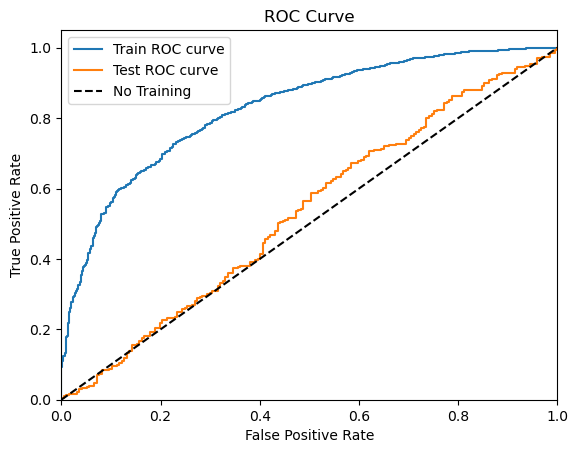

In [41]:
#calculate ROC curve for train loader
fpr, tpr, thresholds = roc_curve(mobnet_groundtrues, mobnet_predictions) 
roc_auc = auc(fpr, tpr)
print("The AUC score of the train loader is: ", roc_auc)

fpr2, tpr2, thresholds2 = roc_curve(mobnet_testgroundtrues, mobnet_testpredictions) 
roc_auc2 = auc(fpr2, tpr2)
print("The AUC score of the test loader is: ", roc_auc2)

# plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='Train ROC curve' % roc_auc)
plt.plot(fpr2, tpr2, label='Test ROC curve' % roc_auc2)
plt.plot([0, 1], [0, 1], 'k--', label='No Training')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

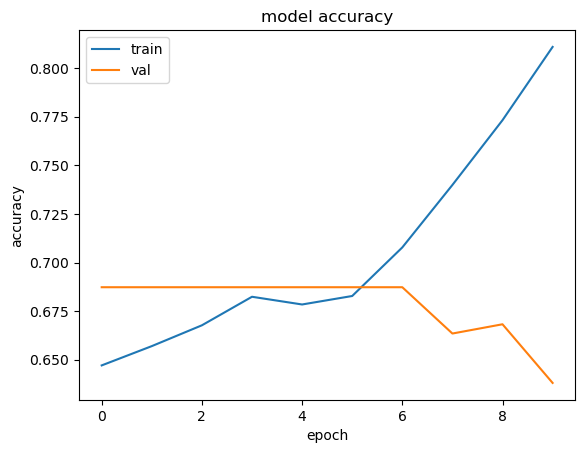

In [42]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

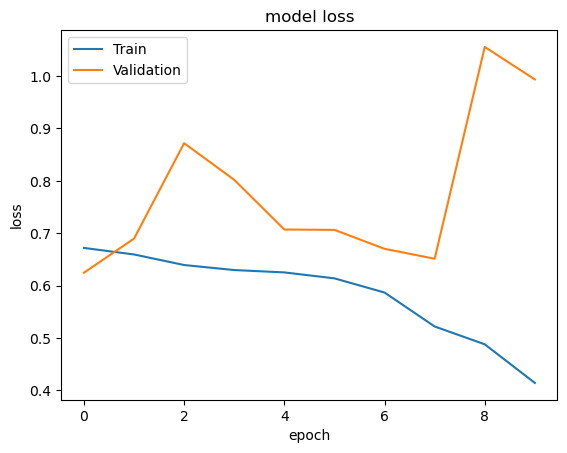

In [43]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [44]:
img = keras.utils.load_img('C:\\Users\\xiuli\\MHIST\\folder\\images\\MHIST_aaa.png') #evaluate on SSA image
img_array = keras.utils.img_to_array(img)
img_array = np.array([img_array]) 
predictions = model3.predict(img_array)
class_id = np.argmax(predictions, axis = 1)
print(class_id) #show the class id

#note: since I converted SSA and HP labels into binary digits, SSA is 0 and HP is 1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[0]


In [45]:
img = keras.utils.load_img('C:\\Users\\xiuli\\MHIST\\folder\\images\\MHIST_aag.png')
img_array = keras.utils.img_to_array(img)
img_array = np.array([img_array]) 
predictions = model3.predict(img_array)
class_id = np.argmax(predictions, axis = 1)
print(class_id)

#note: since I converted SSA and HP labels into binary digits, SSA is 0 and HP is 1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
[0]
